In [27]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, List

In [28]:
@dataclass
class Function:
    func: Callable[[float], float]
    derivative: Callable[[float], float]

In [29]:
class Perceptron:
    def __init__(
        self,
        input_layer_size: int,
        hidden_layers_sizes: tuple,
        output_layer_size: int,
        init_weights_function: Callable[[tuple], tuple],
        activation_functions: tuple,  # Кортеж функций активации для каждого скрытого слоя
        output_activation_function: Function,
        loss_function: Function,
        epochs: int,
        learning_rate: float = 0.01,
    ):
        self.input_layer_size = input_layer_size
        self.hidden_layers_sizes = hidden_layers_sizes  # Кортеж с размерами скрытых слоев
        self.output_layer_size = output_layer_size
        self.activation_functions = activation_functions  # Кортеж с функциями активации
        self.output_activation_function = output_activation_function
        self.loss_function = loss_function
        self.epochs = epochs
        self.learning_rate = learning_rate

        # Инициализация весов и смещений (biases)
        self.weights = []
        self.biases = []

        # Веса между входным слоем и первым скрытым слоем
        self.weights.append(init_weights_function((hidden_layers_sizes[0], input_layer_size)))
        self.biases.append(np.random.randn(hidden_layers_sizes[0]))

        # Веса между скрытыми слоями
        for i in range(1, len(hidden_layers_sizes)):
            self.weights.append(init_weights_function((hidden_layers_sizes[i], hidden_layers_sizes[i - 1])))
            self.biases.append(np.random.randn(hidden_layers_sizes[i]))

        # Веса между последним скрытым слоем и выходным слоем
        self.weights.append(init_weights_function((output_layer_size, hidden_layers_sizes[-1])))
        self.biases.append(np.random.randn(output_layer_size))

    def predict(self, X: np.ndarray, get_probabilities: bool = False) -> int | list:
        current_input = X

        # Прямой проход через скрытые слои с индивидуальными функциями активации
        for i in range(len(self.hidden_layers_sizes)):
            z = np.dot(self.weights[i], current_input) + self.biases[i]
            current_input = self.activation_functions[i].func(z)  # Применение индивидуальной функции активации

        # Прямой проход через выходной слой
        z = np.dot(self.weights[-1], current_input) + self.biases[-1]
        output = self.output_activation_function.func(z)

        return output if get_probabilities else int(np.argmax(output))

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Преобразуем метки y в формат "one-hot encoding"
        y_one_hot = np.zeros((len(y), self.output_layer_size))
        for i, label in enumerate(y):
            y_one_hot[i, label] = 1

        for epoch in range(self.epochs):
            for i in range(len(X)):
                # Прямой проход (вычисление предсказания)
                outputs = [X[i]]  # Сохраняем выходы каждого слоя
                current_input = np.array(X[i])

                # Прямой проход через скрытые слои с индивидуальными функциями активации
                for j in range(len(self.hidden_layers_sizes)):
                    z = np.dot(self.weights[j], current_input) + self.biases[j]
                    current_input = self.activation_functions[j].func(z)
                    outputs.append(current_input)

                # Прямой проход через выходной слой
                z = np.dot(self.weights[-1], current_input) + self.biases[-1]
                output = self.output_activation_function.func(z)
                outputs.append(output)

                # Вычисление ошибки и градиента функции потерь
                loss_gradient = self.loss_function.derivative(output, y_one_hot[i])

                # Обратное распространение ошибки для выходного слоя

                # Вычисление матрицы Якобиана
                jacobian = self.output_activation_function.derivative(output)

                # Градиент по логитам (умножение матрицы Якобиана на градиент функции потерь)
                delta = np.dot(jacobian, loss_gradient)
                self.weights[-1] -= self.learning_rate * np.outer(delta, outputs[-2])
                self.biases[-1] -= self.learning_rate * delta

                # Обратное распространение для скрытых слоев с индивидуальными функциями активации
                for j in range(len(self.hidden_layers_sizes) - 1, -1, -1):
                    jacobian = self.activation_functions[j].derivative(outputs[j + 1])
                    delta = np.dot(jacobian, np.dot(self.weights[j + 1].T, delta))
                    self.weights[j] -= self.learning_rate * np.outer(delta, outputs[j])
                    self.biases[j] -= self.learning_rate * delta

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        correct_predictions = 0

        for i in range(len(X)):
            prediction = self.predict(X[i])
            if prediction == y[i]:
                correct_predictions += 1

        # Возвращаем долю правильных предсказаний
        return correct_predictions / len(X)

    def validate(self, X_val: np.ndarray, y_val: np.ndarray) -> float:
        total_loss = 0.0
        n = len(X_val)

        # Преобразуем метки в one-hot encoding, если это необходимо
        y_one_hot = np.zeros((len(y_val), self.output_layer_size))
        for i, label in enumerate(y_val):
            y_one_hot[i, label] = 1

        for i in range(n):
            # Прямой проход для получения предсказания
            prediction = self.predict(X_val[i], get_probabilities=True)

            # Вычисляем функцию потерь для текущего примера
            loss = self.loss_function.func(prediction, y_one_hot[i])
            total_loss += loss

        # Возвращаем среднее значение функции потерь
        return total_loss / n

In [30]:
def he_init(size):
    return np.random.randn(*size) * np.sqrt(2.0 / size[1])

def xavier_init(size):
    return np.random.randn(*size) * np.sqrt(1.0 / size[1])

In [31]:
k = 3
ReLU = Function(
    func=lambda x: np.where(x > 0, k * x, 0),
    derivative=lambda x: np.diag(np.where(x > 0, k, 0)),
)
Softmax = Function(
    func=lambda x: (lambda exp_x: exp_x / (np.sum(exp_x) + 1e-9))(np.exp(x - np.max(x))),
    derivative=lambda x: np.diagflat(x) - np.outer(x, x),
)

In [32]:
MSE = Function(
    func=lambda y_pred, y_true: np.mean((y_true - y_pred) ** 2),
    derivative=lambda y_pred, y_true: 2 * (y_pred - y_true) / y_true.size,
)
CrossEntropy = Function(
    func=lambda y_pred, y_true: -np.log(y_pred[np.argmax(y_true)] + 1e-9),
    derivative=lambda y_pred, y_true: -y_true / (y_pred + 1e-9),
)
KL_Divergence = CrossEntropy

In [33]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28**2) / 255
x_test = x_test.reshape(-1, 28**2) / 255
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [34]:
model_default = Perceptron(
    input_layer_size=784,  # 28**2
    hidden_layers_sizes=(512, 256, 128, 64),
    output_layer_size=10,
    init_weights_function=he_init,
    activation_functions=(ReLU, ReLU, ReLU, ReLU),
    output_activation_function=None,
    loss_function=None,
    epochs=1,
    learning_rate=1e-3,
)

In [35]:
epochs_count = 10
epoch_list = list(range(0, epochs_count + 1))

In [36]:
def get_accuracies(output_activation_function, loss_function):
    model = copy.deepcopy(model_default)
    model.output_activation_function = output_activation_function
    model.loss_function = loss_function

    accuracies = np.array([model.evaluate(x_test, y_test)])
    losses = np.array([model.validate(x_test, y_test)])
    print(accuracies[-1], losses[-1])

    for i in range(1, epochs_count + 1):
        model.fit(x_train, y_train)
        accuracies = np.append(accuracies, model.evaluate(x_test, y_test))
        losses = np.append(losses, model.validate(x_test, y_test))
        print(accuracies[-1], losses[-1])
    
    print()
    return accuracies, losses

In [37]:
ReLU_MSE = get_accuracies(ReLU, MSE)
ReLU_CrEntr = get_accuracies(ReLU, CrossEntropy)
ReLU_KLD = ReLU_CrEntr # get_accuracies(ReLU, KL_Divergence)
Softmax_MSE = get_accuracies(Softmax, MSE)
Softmax_CrEntr = get_accuracies(Softmax, CrossEntropy)
Softmax_KLD = Softmax_CrEntr  # get_accuracies(Softmax, KL_Divergence)

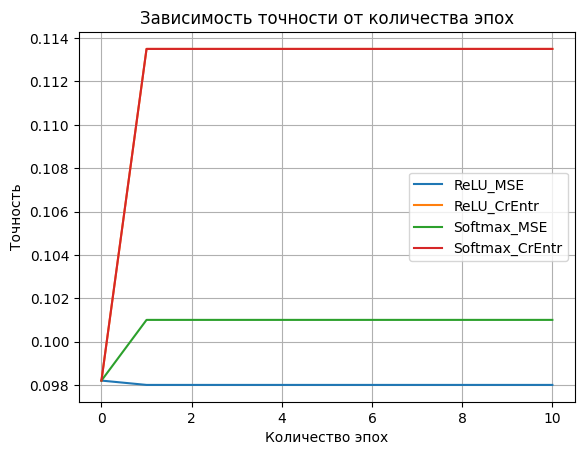

In [38]:
plt.plot(epoch_list, ReLU_MSE[0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[0], label="Softmax_KLD")

plt.title("Зависимость точности от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

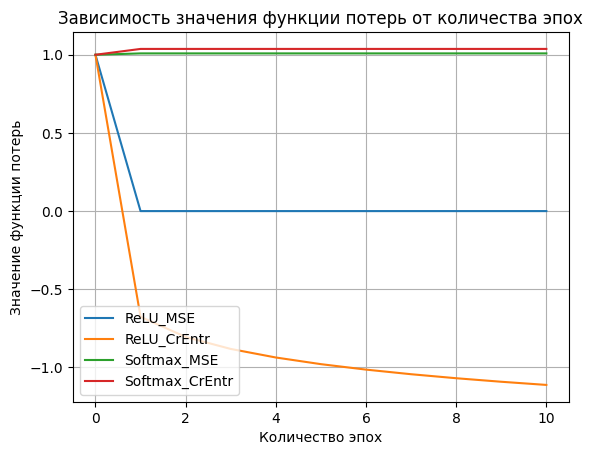

In [39]:
plt.plot(epoch_list, ReLU_MSE[1] / ReLU_MSE[1][0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[1] / ReLU_CrEntr[1][0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[1] / ReLU_KLD[1][0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[1] / Softmax_MSE[1][0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[1] / Softmax_CrEntr[1][0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[1] / Softmax_KLD[1][0], label="Softmax_KLD")

plt.title("Зависимость значения функции потерь от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [40]:
model_default = Perceptron(
    input_layer_size=784,  # 28**2
    hidden_layers_sizes=(256, 128, 64, 32),
    output_layer_size=10,
    init_weights_function=he_init,
    activation_functions=(ReLU, ReLU, ReLU, ReLU),
    output_activation_function=None,
    loss_function=None,
    epochs=1,
    learning_rate=1e-3,
)

In [41]:
ReLU_MSE = get_accuracies(ReLU, MSE)
ReLU_CrEntr = get_accuracies(ReLU, CrossEntropy)
ReLU_KLD = ReLU_CrEntr # get_accuracies(ReLU, KL_Divergence)
Softmax_MSE = get_accuracies(Softmax, MSE)
Softmax_CrEntr = get_accuracies(Softmax, CrossEntropy)
Softmax_KLD = Softmax_CrEntr  # get_accuracies(Softmax, KL_Divergence)

0.0949 9502.644574694106
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588

0.0949 13.458532074249751
0.1028 -12.668901662072196
0.1028 -12.887270877884319
0.1028 -13.030768411167253
0.1028 -13.139536292001125
0.1028 -13.227653355664463
0.1028 -13.301921747070239
0.1028 -13.366202926021652
0.1028 -13.422918157464476
0.1028 -13.473692788931396
0.1028 -13.519673809029475

0.0949 0.17880379558639956
0.0974 0.18051999964976695
0.0974 0.1805199996493653
0.0974 0.1805199996489627
0.0974 0.18051999964855905
0.0974 0.18051999964815435
0.0974 0.18051999964774862
0.0974 0.18051999964734192
0.0974 0.1805199996469341
0.0974 0.18051999964652535
0.0974 0.1805199996461155

0.0949 18.352347339619502
0.0974 18.704819744428054
0.0974 18.704819744428054
0.0974 18.704819744428054
0.0974 18.704819744

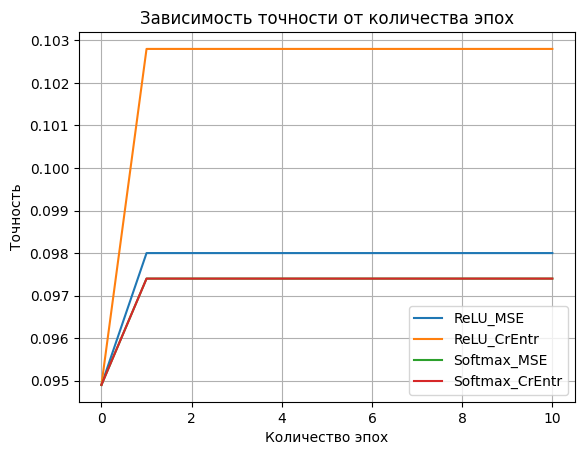

In [42]:
plt.plot(epoch_list, ReLU_MSE[0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[0], label="Softmax_KLD")

plt.title("Зависимость точности от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

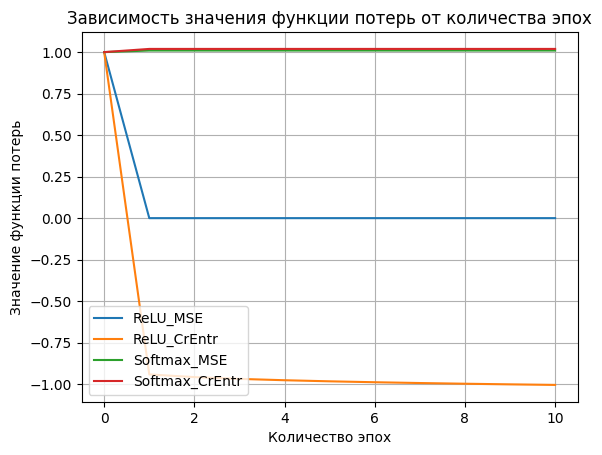

In [43]:
plt.plot(epoch_list, ReLU_MSE[1] / ReLU_MSE[1][0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[1] / ReLU_CrEntr[1][0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[1] / ReLU_KLD[1][0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[1] / Softmax_MSE[1][0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[1] / Softmax_CrEntr[1][0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[1] / Softmax_KLD[1][0], label="Softmax_KLD")

plt.title("Зависимость значения функции потерь от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [44]:
model_default = Perceptron(
    input_layer_size=784,  # 28**2
    hidden_layers_sizes=(256,)*4,
    output_layer_size=10,
    init_weights_function=he_init,
    activation_functions=(ReLU, ReLU, ReLU, ReLU),
    output_activation_function=None,
    loss_function=None,
    epochs=1,
    learning_rate=1e-3,
)

In [45]:
ReLU_MSE = get_accuracies(ReLU, MSE)
ReLU_CrEntr = get_accuracies(ReLU, CrossEntropy)
ReLU_KLD = ReLU_CrEntr # get_accuracies(ReLU, KL_Divergence)
Softmax_MSE = get_accuracies(Softmax, MSE)
Softmax_CrEntr = get_accuracies(Softmax, CrossEntropy)
Softmax_KLD = Softmax_CrEntr  # get_accuracies(Softmax, KL_Divergence)

0.0709 57127.499371250036
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588

0.0709 2.663085555423314
0.1028 -9.569751811419348
0.1028 -10.914535367754596
0.1028 -11.706714818929301
0.1028 -12.27031461076709
0.1028 -12.708119409030196
0.1028 -13.066160382303352
0.1028 -13.369069605537788
0.1028 -13.631580993701194
0.1028 -13.863212407309003
0.1028 -14.070469854493963

0.0709 0.1844088941638664
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414
0.0892 0.18215999981781414

0.0709 18.915803630876013
0.0958 18.737976969767168
0.0958 18.737976969767168
0.098 nan
0.098 nan
0.098 nan
0.098 nan
0.09

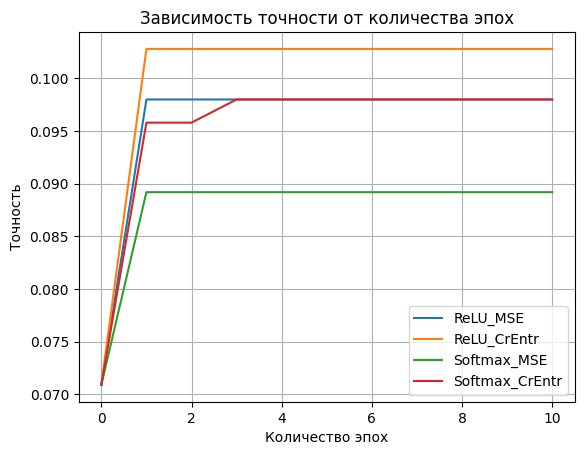

In [46]:
plt.plot(epoch_list, ReLU_MSE[0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[0], label="Softmax_KLD")

plt.title("Зависимость точности от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

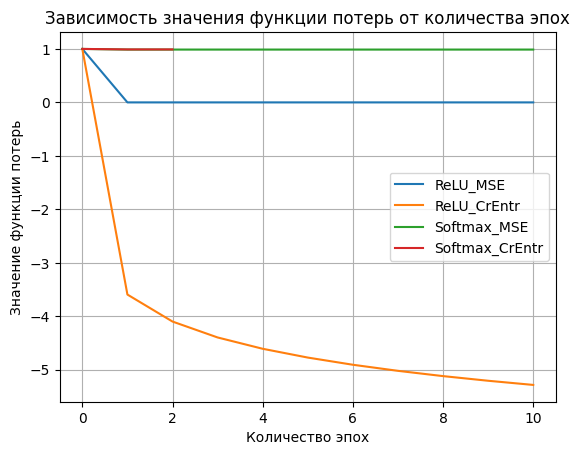

In [47]:
plt.plot(epoch_list, ReLU_MSE[1] / ReLU_MSE[1][0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[1] / ReLU_CrEntr[1][0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[1] / ReLU_KLD[1][0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[1] / Softmax_MSE[1][0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[1] / Softmax_CrEntr[1][0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[1] / Softmax_KLD[1][0], label="Softmax_KLD")

plt.title("Зависимость значения функции потерь от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [48]:
model_default = Perceptron(
    input_layer_size=784,  # 28**2
    hidden_layers_sizes=(256,)*4,
    output_layer_size=10,
    init_weights_function=he_init,
    activation_functions=(ReLU, ReLU, ReLU, ReLU),
    output_activation_function=None,
    loss_function=None,
    epochs=1,
    learning_rate=1e-6,
)

In [49]:
ReLU_MSE = get_accuracies(ReLU, MSE)
ReLU_CrEntr = get_accuracies(ReLU, CrossEntropy)
ReLU_KLD = ReLU_CrEntr # get_accuracies(ReLU, KL_Divergence)
Softmax_MSE = get_accuracies(Softmax, MSE)
Softmax_CrEntr = get_accuracies(Softmax, CrossEntropy)
Softmax_KLD = Softmax_CrEntr  # get_accuracies(Softmax, KL_Divergence)

0.0689 43428.182637584956
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588

0.0689 10.556735872047646
0.1003 1.3539513188569012
0.1009 1.0888421313741203
0.1014 0.8988941335066185
0.1051 0.7449160412872071
0.1072 0.6134881969391717
0.1115 0.4977809930337429
0.114 0.3936154059021844
0.1201 0.29834598505792115
0.1272 0.21022484560570392
0.1352 0.12801937616267609

0.0689 0.1842331591134057
0.0798 0.18276226784824232
0.0828 0.18204518772268738
0.0859 0.18065371512552464
0.1029 0.1770185062452941
0.1113 0.17499947885297962
0.1242 0.1726975562267603
0.1322 0.17086587189166136
0.138 0.16966317900655692
0.1452 0.16829004651646634
0.1499 0.16742682657580946

0.0689 18.8763046396805
0.2839 14.65062539154717
0.2916 14.544674374866046
0.295 14.504352007215743
0.2967 14.490661785905305
0.29

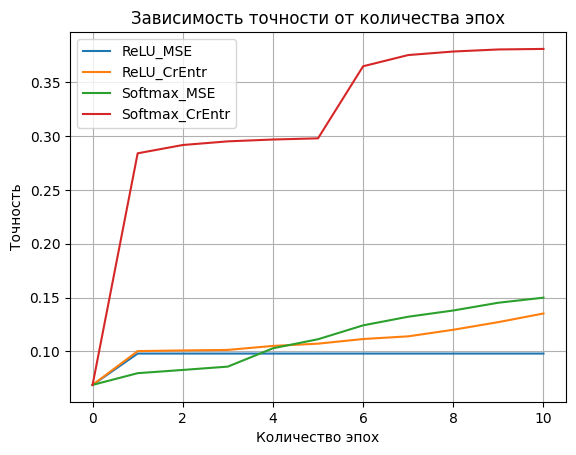

In [51]:
plt.plot(epoch_list, ReLU_MSE[0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[0], label="Softmax_KLD")

plt.title("Зависимость точности от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

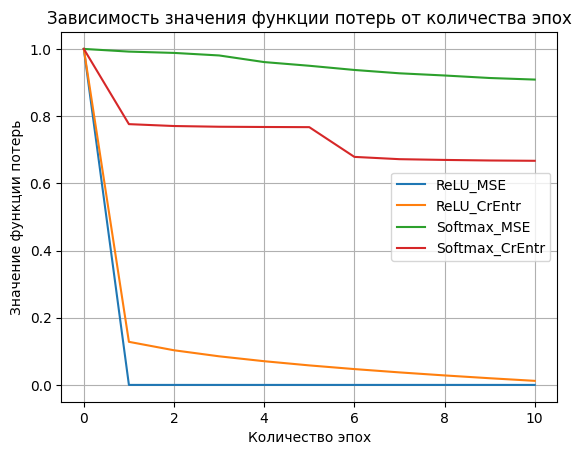

In [50]:
plt.plot(epoch_list, ReLU_MSE[1] / ReLU_MSE[1][0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[1] / ReLU_CrEntr[1][0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[1] / ReLU_KLD[1][0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[1] / Softmax_MSE[1][0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[1] / Softmax_CrEntr[1][0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[1] / Softmax_KLD[1][0], label="Softmax_KLD")

plt.title("Зависимость значения функции потерь от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()